In [234]:
# Notes on what to try
# smooth series with moving averages
# first order differences on everything
# second order differences
# better data transformations to reduce noise

In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [216]:
raw = pd.read_csv("./data/BTC/BTC_Book_0.zip", compression = 'zip', parse_dates = True, index_col = 0)
prices = raw[raw.columns[1::3]]
sizes = raw[raw.columns[2::3]]
trades = raw[raw.columns[3::3]]

In [217]:
mid_price = (prices['Ask_1_Price'] + prices['Bid_1_Price'])/2
features = pd.DataFrame(mid_price, columns = ['mid_price'])

features['return'] = features['mid_price'].diff(1)
features['fut_return'] = features['return'].shift(-1)
features['return_up'] = (features['fut_return'] > 0).astype(int)
features['return_down'] = (features['fut_return'] < 0).astype(int)
features['return_unch'] = (features['fut_return'] == 0).astype(int)

features['Spread'] = prices['Ask_1_Price'] - prices['Bid_1_Price']
features['Bid_Dist'] = prices['Bid_1_Price'] - prices['Bid_50_Price']
features['Ask_Dist'] = prices['Ask_50_Price'] - prices['Ask_1_Price']

features['Level_1_Size_IMB'] = sizes['Ask_1_Size'] - sizes['Bid_1_Size']
features['Ask_1_Size'] = sizes['Ask_1_Size']
features['Bid_1_Size'] = sizes['Bid_1_Size']

bid_sizes = sizes[sizes.columns[:50]]
features['Cumu_Bids'] = bid_sizes.cumsum(axis=1)['Bid_50_Size']

ask_sizes = sizes[sizes.columns[50:]]
features['Cumu_Asks'] = ask_sizes.cumsum(axis=1)['Ask_50_Size']

features['Cumu_Size_IMB'] = features['Cumu_Asks'] - features['Cumu_Bids']


features.head()

features = features.dropna()
#### Transform spread, BID, ASK SIZE, BID ASK DIST

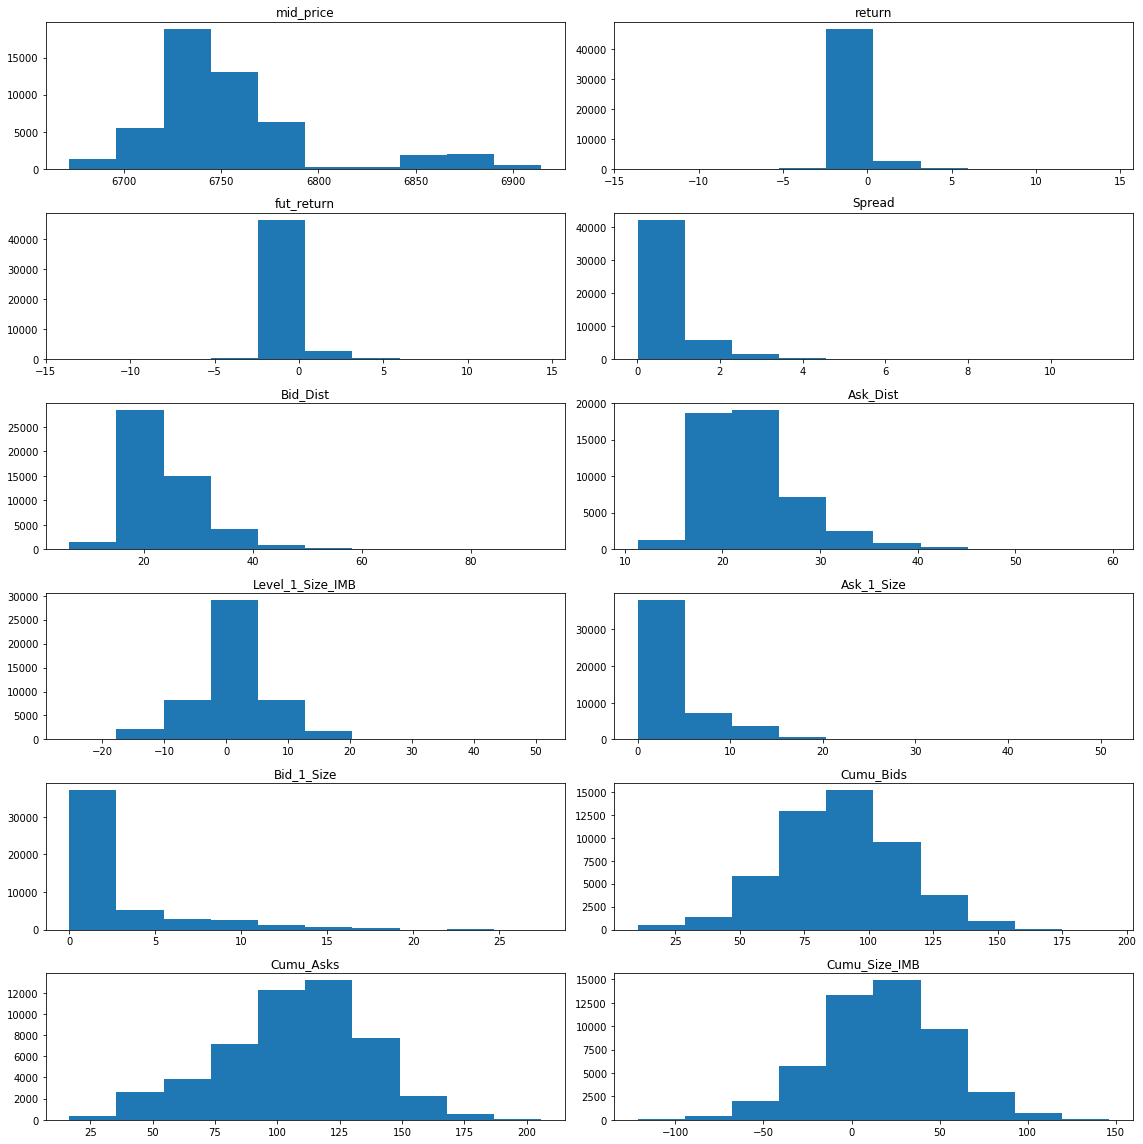

In [218]:
feature_drop = features.drop(columns = ['return_up','return_down','return_unch']).dropna()

fig, ax = plt.subplots(6,2, figsize = (16,16))

for i in range(6):
    for j in range(2):
        ax[i][j].hist(feature_drop[feature_drop.columns[2*i+j]])
        ax[i][j].set_title(feature_drop.columns[2*i+j])
        
fig.tight_layout()

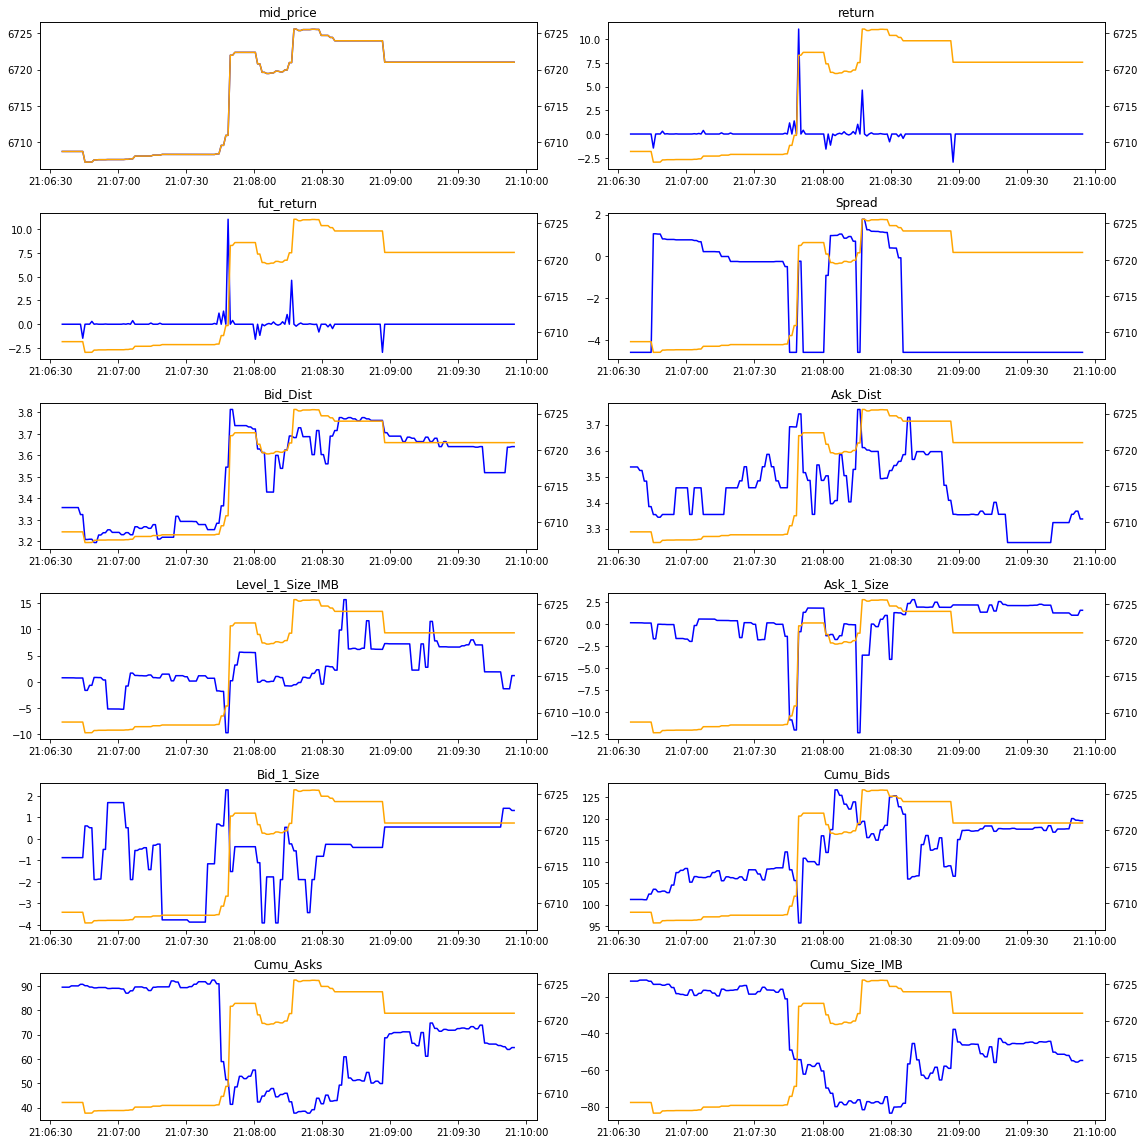

In [232]:
fig, ax = plt.subplots(6,2, figsize = (16,16))

for i in range(6):
    for j in range(2):
        ax[i][j].plot(feature_drop[feature_drop.columns[2*i+j]][:200], color = 'blue')
        ax[i][j].set_title(feature_drop.columns[2*i+j])
        
        ax_other = ax[i][j].twinx()
        ax_other.plot(feature_drop['mid_price'][:200], color = 'orange')
        
fig.tight_layout()

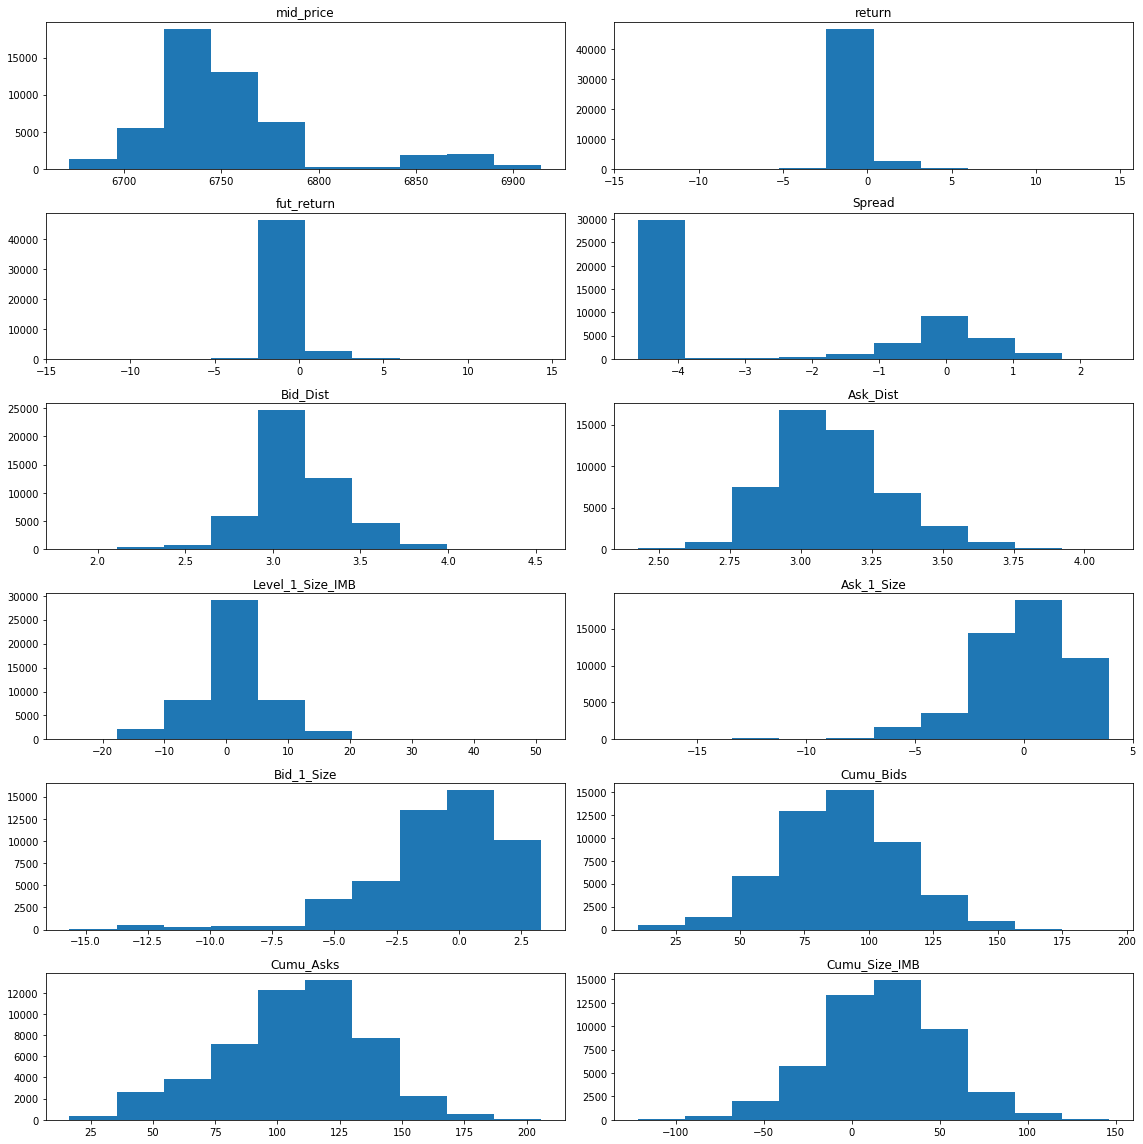

In [219]:
feature_drop['Spread'] = np.log(feature_drop['Spread'].values)
feature_drop['Bid_1_Size'] = np.log(features['Bid_1_Size'].values)
feature_drop['Ask_1_Size'] = np.log(features['Ask_1_Size'].values)
feature_drop['Bid_Dist'] = np.log(feature_drop['Bid_Dist'].values)
feature_drop['Ask_Dist'] = np.log(feature_drop['Ask_Dist'].values)

fig, ax = plt.subplots(6,2, figsize = (16,16))

for i in range(6):
    for j in range(2):
        ax[i][j].hist(feature_drop[feature_drop.columns[2*i+j]])
        ax[i][j].set_title(feature_drop.columns[2*i+j])
        
fig.tight_layout()

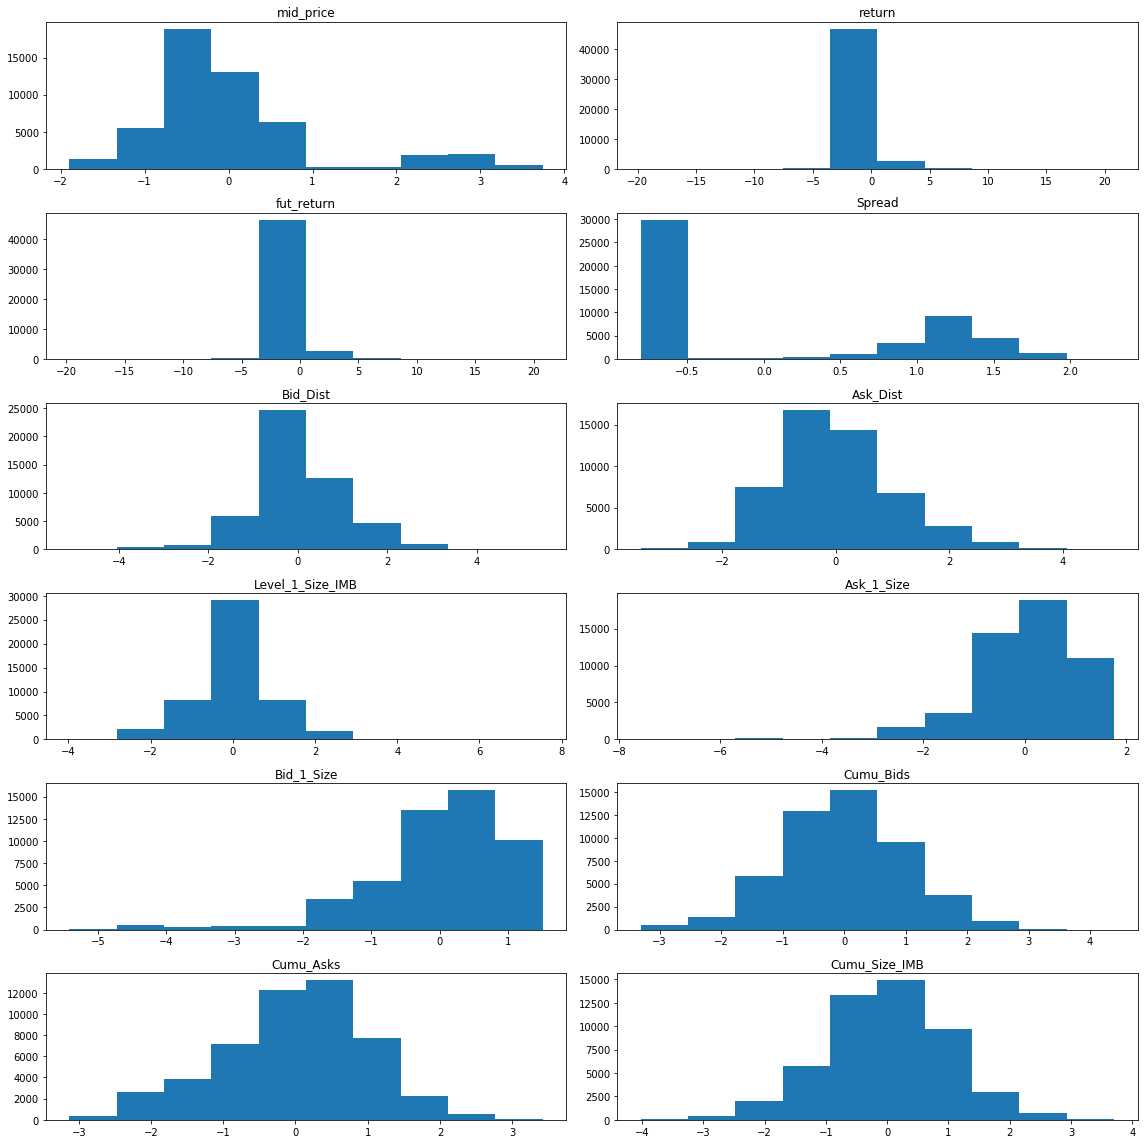

In [220]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(feature_drop)
feature_scaled = scaler.transform(feature_drop)

fig, ax = plt.subplots(6,2, figsize = (16,16))

for i in range(6):
    for j in range(2):
        ax[i][j].hist(feature_scaled[:,[2*i+j]])
        ax[i][j].set_title(feature_drop.columns[2*i+j])
        
fig.tight_layout()

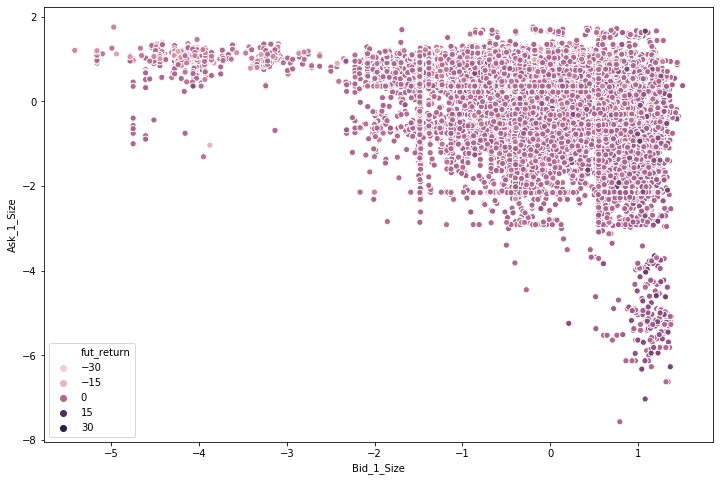

In [228]:
fig, ax = plt.subplots(1,1, figsize = (12,8))

sns.scatterplot('Bid_1_Size', 'Ask_1_Size', 
              hue = 'fut_return',
              data = pd.DataFrame(feature_scaled, columns = feature_drop.columns), ax = ax)

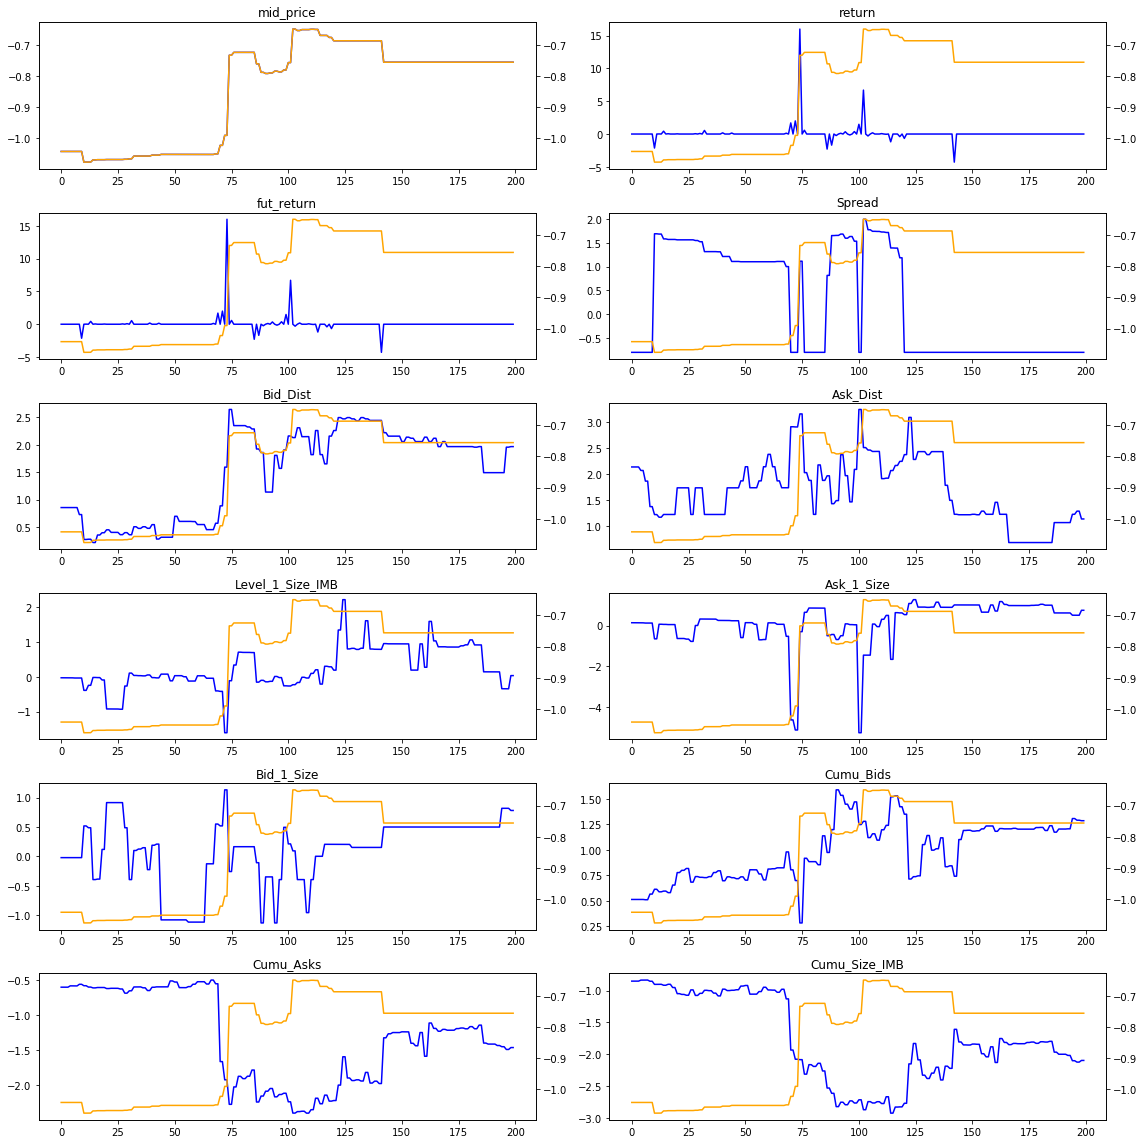

In [233]:
fig, ax = plt.subplots(6,2, figsize = (16,16))

for i in range(6):
    for j in range(2):
        ax[i][j].plot(feature_scaled[:,[2*i+j]][:200], color = 'blue')
        ax[i][j].set_title(feature_drop.columns[2*i+j])
        
        ax_other = ax[i][j].twinx()
        ax_other.plot(feature_scaled[:,0][:200], color = 'orange')
        
fig.tight_layout()

In [236]:
cleaned = pd.DataFrame(feature_scaled, columns = feature_drop.columns)
feature_norm = cleaned.drop(columns = ['return', 'fut_return'])

In [ ]:
fig, axs = plt.subplots(1, figsize = (12,12))
axs = sns.heatmap(cleaned.corr(), xticklabels=cleaned.columns, yticklabels=cleaned.columns, square=True)

In [ ]:
# TEMP Testing model out
feature_norm = feature_norm.values

In [239]:
import torch
import torch.nn as nn

def rolling_window(a, window_size):
    shape = (a.shape[0] - window_size + 1, window_size) + a.shape[1:]
    strides = (a.strides[0],) + a.strides
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


subsets = rolling_window(feature_norm,98)
X = subsets[:len(subsets)-1]
Y = subsets[1:][:,-1,0]

X = torch.Tensor(X)
Y = torch.Tensor(np.expand_dims(Y,1))

print(X.shape)
print(Y.shape)

torch.Size([49900, 98, 10])
torch.Size([49900, 1])


In [240]:
class RecurrentModel(nn.Module):
    def __init__(self, INPUT_SIZE, HIDDEN_SIZE, N_LAYERS, OUTPUT_SIZE):
        super(RecurrentModel, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size = INPUT_SIZE,
            hidden_size = HIDDEN_SIZE, # number of hidden units
            num_layers = N_LAYERS, # number of layers
            batch_first = True
        )
        
        self.out = nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE)
            
    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        # r_out, (h_n, h_c) = self.rnn(x, None) # None represents zero initial hidden state
            
        r_out, h = self.lstm(x, None) # None represents zero initial hidden state
            
        # to choose last time step of output, use -1 in center index
            
        out = self.out(r_out[:, -1, :])
        return out

    
n_hidden = 20
price_model = RecurrentModel(10, n_hidden, 1, 1)
return_model = RecurrentModel(10, n_hidden, 1, 1)

In [241]:
def train_model(model, LR, n_epochs, X_BATCH, Y_BATCH):
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)   # optimize all rnn parameters
    loss_func = nn.MSELoss()  

    all_losses = []
    all_accuracies = []

    for epoch in range(1,n_epochs+1):
        if epoch % 4 == 0:
            for param in optimizer.param_groups:
                param['lr'] = param['lr']/2 

        for i in range(len(X_BATCH)):

            train_x = X_BATCH[i]
            train_y = Y_BATCH[i]

            output = model(train_x)
            loss = loss_func(output, train_y)                # compute loss                      
            optimizer.zero_grad()                            # clear gradients for this training step
            loss.backward()                                  # backpropagation, compute gradients
            optimizer.step()                                 # apply gradient step

            all_losses.append(loss.item())                   #track loss

    #     #compute accuracy
    #     acc_output = rnn(b_x)
    #     pred_y = torch.max(acc_output,1)[1].data.numpy().squeeze()
    #     target = torch.max(b_y,1)[1].data.numpy().squeeze()
    #     train_accuracy = sum(pred_y==target)/b_y.size(0)

            #print info
            print("Epoch: ", epoch, "| train loss: %.4f" % loss.item())#, "| train accuracy: %.8f" % train_accuracy)

    return all_losses, all_accuracies

Epoch:  1 | train loss: 0.5591
Epoch:  1 | train loss: 0.0209
Epoch:  1 | train loss: 0.2830
Epoch:  1 | train loss: 0.4755
Epoch:  1 | train loss: 0.0757
Epoch:  1 | train loss: 0.2893
Epoch:  1 | train loss: 0.0918
Epoch:  1 | train loss: 0.0218
Epoch:  1 | train loss: 0.0889
Epoch:  1 | train loss: 0.0594
Epoch:  1 | train loss: 0.0074
Epoch:  1 | train loss: 0.0245
Epoch:  1 | train loss: 0.0826
Epoch:  1 | train loss: 0.4391
Epoch:  1 | train loss: 0.5584
Epoch:  1 | train loss: 0.6211
Epoch:  1 | train loss: 0.1344
Epoch:  1 | train loss: 0.0620
Epoch:  1 | train loss: 0.3724
Epoch:  1 | train loss: 0.5374
Epoch:  1 | train loss: 0.3182
Epoch:  1 | train loss: 0.3546
Epoch:  1 | train loss: 0.1812
Epoch:  1 | train loss: 0.1152
Epoch:  1 | train loss: 0.0214
Epoch:  1 | train loss: 0.0638
Epoch:  1 | train loss: 0.0857
Epoch:  1 | train loss: 0.1392
Epoch:  1 | train loss: 0.7871
Epoch:  1 | train loss: 0.9630
Epoch:  1 | train loss: 1.2082
Epoch:  1 | train loss: 0.5122
Epoch:  

Epoch:  3 | train loss: 0.2481
Epoch:  3 | train loss: 0.1606
Epoch:  3 | train loss: 0.2344
Epoch:  3 | train loss: 0.1113
Epoch:  3 | train loss: 0.0310
Epoch:  3 | train loss: 0.0664
Epoch:  3 | train loss: 0.0868
Epoch:  3 | train loss: 0.0351
Epoch:  3 | train loss: 0.0457
Epoch:  3 | train loss: 0.0318
Epoch:  3 | train loss: 0.0105
Epoch:  3 | train loss: 0.0082
Epoch:  3 | train loss: 0.0344
Epoch:  3 | train loss: 0.0363
Epoch:  3 | train loss: 0.0240
Epoch:  3 | train loss: 0.0459
Epoch:  3 | train loss: 0.0505
Epoch:  3 | train loss: 0.0470
Epoch:  3 | train loss: 0.0391
Epoch:  3 | train loss: 0.0085
Epoch:  3 | train loss: 0.0329
Epoch:  3 | train loss: 0.1538
Epoch:  3 | train loss: 0.1685
Epoch:  3 | train loss: 0.1506
Epoch:  3 | train loss: 0.0201
Epoch:  3 | train loss: 0.0847
Epoch:  3 | train loss: 1.2826
Epoch:  3 | train loss: 1.3035
Epoch:  3 | train loss: 0.7333
Epoch:  3 | train loss: 0.1032
Epoch:  3 | train loss: 0.0719
Epoch:  3 | train loss: 0.0786
Epoch:  

Epoch:  6 | train loss: 0.0738
Epoch:  6 | train loss: 0.0304
Epoch:  6 | train loss: 0.0112
Epoch:  6 | train loss: 0.0195
Epoch:  6 | train loss: 0.0189
Epoch:  6 | train loss: 0.0153
Epoch:  6 | train loss: 0.0097
Epoch:  6 | train loss: 0.0088
Epoch:  6 | train loss: 0.0144
Epoch:  6 | train loss: 0.0218
Epoch:  6 | train loss: 0.0203
Epoch:  6 | train loss: 0.0826
Epoch:  6 | train loss: 0.1877
Epoch:  6 | train loss: 0.2424
Epoch:  6 | train loss: 0.3328
Epoch:  6 | train loss: 0.3584
Epoch:  6 | train loss: 0.1576
Epoch:  6 | train loss: 0.0561
Epoch:  6 | train loss: 0.0313
Epoch:  6 | train loss: 0.0563
Epoch:  6 | train loss: 0.0282
Epoch:  6 | train loss: 0.0162
Epoch:  6 | train loss: 0.0261
Epoch:  6 | train loss: 0.0410
Epoch:  6 | train loss: 0.0457
Epoch:  6 | train loss: 0.0353
Epoch:  6 | train loss: 0.0091
Epoch:  6 | train loss: 0.0183
Epoch:  6 | train loss: 0.0173
Epoch:  6 | train loss: 0.0175
Epoch:  6 | train loss: 0.0958
Epoch:  6 | train loss: 0.0511
Epoch:  

Epoch:  8 | train loss: 0.0781
Epoch:  8 | train loss: 0.0342
Epoch:  8 | train loss: 0.0281
Epoch:  8 | train loss: 0.0322
Epoch:  8 | train loss: 0.0632
Epoch:  9 | train loss: 0.0298
Epoch:  9 | train loss: 0.0148
Epoch:  9 | train loss: 0.0192
Epoch:  9 | train loss: 0.0351
Epoch:  9 | train loss: 0.0394
Epoch:  9 | train loss: 0.0125
Epoch:  9 | train loss: 0.0244
Epoch:  9 | train loss: 0.0225
Epoch:  9 | train loss: 0.0531
Epoch:  9 | train loss: 0.1161
Epoch:  9 | train loss: 0.0093
Epoch:  9 | train loss: 0.0068
Epoch:  9 | train loss: 0.0327
Epoch:  9 | train loss: 0.0326
Epoch:  9 | train loss: 0.0190
Epoch:  9 | train loss: 0.0593
Epoch:  9 | train loss: 0.0131
Epoch:  9 | train loss: 0.0058
Epoch:  9 | train loss: 0.0115
Epoch:  9 | train loss: 0.0121
Epoch:  9 | train loss: 0.0116
Epoch:  9 | train loss: 0.0122
Epoch:  9 | train loss: 0.0095
Epoch:  9 | train loss: 0.0082
Epoch:  9 | train loss: 0.0196
Epoch:  9 | train loss: 0.0304
Epoch:  9 | train loss: 0.0090
Epoch:  

Epoch:  11 | train loss: 0.0028
Epoch:  11 | train loss: 0.0046
Epoch:  11 | train loss: 0.0029
Epoch:  11 | train loss: 0.0021
Epoch:  11 | train loss: 0.0013
Epoch:  11 | train loss: 0.0032
Epoch:  11 | train loss: 0.0065
Epoch:  11 | train loss: 0.0059
Epoch:  11 | train loss: 0.0076
Epoch:  11 | train loss: 0.0028
Epoch:  11 | train loss: 0.0013
Epoch:  11 | train loss: 0.0029
Epoch:  11 | train loss: 0.0148
Epoch:  11 | train loss: 0.0193
Epoch:  11 | train loss: 0.0042
Epoch:  11 | train loss: 0.0018
Epoch:  11 | train loss: 0.0014
Epoch:  11 | train loss: 0.0011
Epoch:  11 | train loss: 0.0016
Epoch:  11 | train loss: 0.0060
Epoch:  11 | train loss: 0.0012
Epoch:  11 | train loss: 0.0011
Epoch:  11 | train loss: 0.0023
Epoch:  11 | train loss: 0.0039
Epoch:  11 | train loss: 0.0069
Epoch:  11 | train loss: 0.0045
Epoch:  11 | train loss: 0.0038
Epoch:  11 | train loss: 0.0049
Epoch:  11 | train loss: 0.0051
Epoch:  11 | train loss: 0.0027
Epoch:  11 | train loss: 0.0057
Epoch:  

Epoch:  14 | train loss: 0.0033
Epoch:  14 | train loss: 0.0044
Epoch:  14 | train loss: 0.0022
Epoch:  14 | train loss: 0.0076
Epoch:  14 | train loss: 0.0016
Epoch:  14 | train loss: 0.0038
Epoch:  14 | train loss: 0.0057
Epoch:  14 | train loss: 0.0015
Epoch:  14 | train loss: 0.0023
Epoch:  14 | train loss: 0.0022
Epoch:  14 | train loss: 0.0016
Epoch:  14 | train loss: 0.0011
Epoch:  14 | train loss: 0.0033
Epoch:  14 | train loss: 0.0037
Epoch:  14 | train loss: 0.0014
Epoch:  14 | train loss: 0.0041
Epoch:  14 | train loss: 0.0098
Epoch:  14 | train loss: 0.0051
Epoch:  14 | train loss: 0.0037
Epoch:  14 | train loss: 0.0033
Epoch:  14 | train loss: 0.0018
Epoch:  14 | train loss: 0.0040
Epoch:  14 | train loss: 0.0019
Epoch:  14 | train loss: 0.0029
Epoch:  14 | train loss: 0.0017
Epoch:  14 | train loss: 0.0016
Epoch:  14 | train loss: 0.0015
Epoch:  14 | train loss: 0.0030
Epoch:  14 | train loss: 0.0024
Epoch:  14 | train loss: 0.0042
Epoch:  14 | train loss: 0.0033
Epoch:  

Epoch:  16 | train loss: 0.0010
Epoch:  16 | train loss: 0.0008
Epoch:  16 | train loss: 0.0006
Epoch:  16 | train loss: 0.0008
Epoch:  16 | train loss: 0.0011
Epoch:  16 | train loss: 0.0039
Epoch:  16 | train loss: 0.0005
Epoch:  16 | train loss: 0.0005
Epoch:  16 | train loss: 0.0017
Epoch:  16 | train loss: 0.0017
Epoch:  16 | train loss: 0.0019
Epoch:  16 | train loss: 0.0016
Epoch:  16 | train loss: 0.0017
Epoch:  16 | train loss: 0.0019
Epoch:  16 | train loss: 0.0023
Epoch:  16 | train loss: 0.0026
Epoch:  16 | train loss: 0.0027
Epoch:  16 | train loss: 0.0030
Epoch:  16 | train loss: 0.0011
Epoch:  16 | train loss: 0.0009
Epoch:  16 | train loss: 0.0022
Epoch:  16 | train loss: 0.0086
Epoch:  16 | train loss: 0.0241
Epoch:  16 | train loss: 0.0235
Epoch:  16 | train loss: 0.0097
Epoch:  16 | train loss: 0.0170
Epoch:  16 | train loss: 0.0135
Epoch:  16 | train loss: 0.0181
Epoch:  16 | train loss: 0.0124
Epoch:  16 | train loss: 0.0072
Epoch:  16 | train loss: 0.0171
Epoch:  

Epoch:  19 | train loss: 0.0012
Epoch:  19 | train loss: 0.0033
Epoch:  19 | train loss: 0.0076
Epoch:  19 | train loss: 0.0032
Epoch:  19 | train loss: 0.0020
Epoch:  19 | train loss: 0.0024
Epoch:  19 | train loss: 0.0016
Epoch:  19 | train loss: 0.0034
Epoch:  19 | train loss: 0.0019
Epoch:  19 | train loss: 0.0022
Epoch:  19 | train loss: 0.0012
Epoch:  19 | train loss: 0.0010
Epoch:  19 | train loss: 0.0010
Epoch:  19 | train loss: 0.0017
Epoch:  19 | train loss: 0.0017
Epoch:  19 | train loss: 0.0027
Epoch:  19 | train loss: 0.0026
Epoch:  19 | train loss: 0.0026
Epoch:  19 | train loss: 0.0035
Epoch:  19 | train loss: 0.0167
Epoch:  19 | train loss: 0.0031
Epoch:  19 | train loss: 0.0018
Epoch:  19 | train loss: 0.0025
Epoch:  19 | train loss: 0.0023
Epoch:  19 | train loss: 0.0008
Epoch:  19 | train loss: 0.0010
Epoch:  19 | train loss: 0.0011
Epoch:  19 | train loss: 0.0008
Epoch:  19 | train loss: 0.0014
Epoch:  19 | train loss: 0.0011
Epoch:  19 | train loss: 0.0014
Epoch:  

Epoch:  21 | train loss: 0.0018
Epoch:  21 | train loss: 0.0022
Epoch:  21 | train loss: 0.0023
Epoch:  21 | train loss: 0.0025
Epoch:  21 | train loss: 0.0009
Epoch:  21 | train loss: 0.0008
Epoch:  21 | train loss: 0.0018
Epoch:  21 | train loss: 0.0073
Epoch:  21 | train loss: 0.0180
Epoch:  21 | train loss: 0.0181
Epoch:  21 | train loss: 0.0064
Epoch:  21 | train loss: 0.0133
Epoch:  21 | train loss: 0.0101
Epoch:  21 | train loss: 0.0148
Epoch:  21 | train loss: 0.0106
Epoch:  21 | train loss: 0.0056
Epoch:  21 | train loss: 0.0127
Epoch:  22 | train loss: 0.0022
Epoch:  22 | train loss: 0.0012
Epoch:  22 | train loss: 0.0014
Epoch:  22 | train loss: 0.0026
Epoch:  22 | train loss: 0.0025
Epoch:  22 | train loss: 0.0031
Epoch:  22 | train loss: 0.0056
Epoch:  22 | train loss: 0.0027
Epoch:  22 | train loss: 0.0031
Epoch:  22 | train loss: 0.0010
Epoch:  22 | train loss: 0.0009
Epoch:  22 | train loss: 0.0009
Epoch:  22 | train loss: 0.0022
Epoch:  22 | train loss: 0.0030
Epoch:  

Epoch:  24 | train loss: 0.0015
Epoch:  24 | train loss: 0.0022
Epoch:  24 | train loss: 0.0022
Epoch:  24 | train loss: 0.0022
Epoch:  24 | train loss: 0.0032
Epoch:  24 | train loss: 0.0146
Epoch:  24 | train loss: 0.0028
Epoch:  24 | train loss: 0.0016
Epoch:  24 | train loss: 0.0022
Epoch:  24 | train loss: 0.0020
Epoch:  24 | train loss: 0.0007
Epoch:  24 | train loss: 0.0009
Epoch:  24 | train loss: 0.0008
Epoch:  24 | train loss: 0.0006
Epoch:  24 | train loss: 0.0011
Epoch:  24 | train loss: 0.0009
Epoch:  24 | train loss: 0.0010
Epoch:  24 | train loss: 0.0007
Epoch:  24 | train loss: 0.0008
Epoch:  24 | train loss: 0.0004
Epoch:  24 | train loss: 0.0017
Epoch:  24 | train loss: 0.0024
Epoch:  24 | train loss: 0.0020
Epoch:  24 | train loss: 0.0027
Epoch:  24 | train loss: 0.0008
Epoch:  24 | train loss: 0.0005
Epoch:  24 | train loss: 0.0008
Epoch:  24 | train loss: 0.0026
Epoch:  24 | train loss: 0.0033
Epoch:  24 | train loss: 0.0008
Epoch:  24 | train loss: 0.0006
Epoch:  

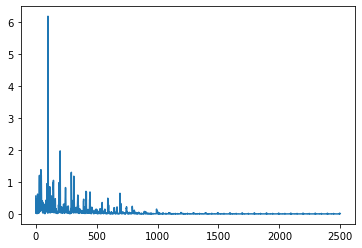

In [242]:
losses, accuracies = train_model(price_model, 
                                 LR=0.05, 
                                 n_epochs=25, 
                                 X_BATCH = np.split(X,100), 
                                 Y_BATCH = np.split(Y, 100)
                                )

plt.plot(losses)

In [243]:
out = price_model(X)
out_np = out.detach().numpy().squeeze()

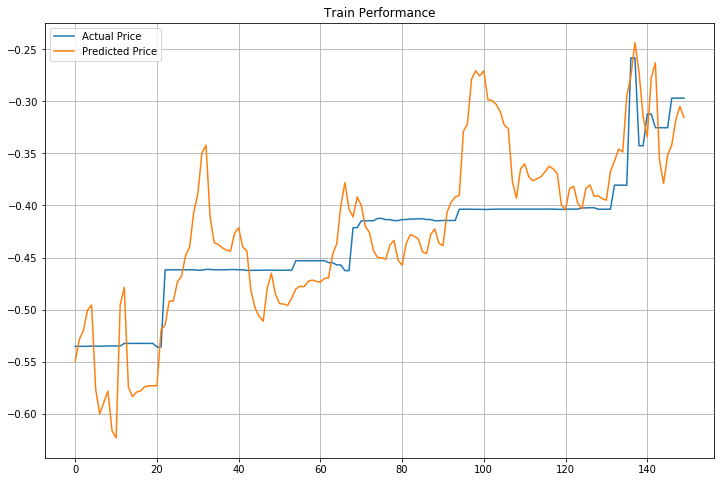

In [256]:
start = 1500
window = 150

fig, ax = plt.subplots(1,1, figsize = (12,8))
ax.plot(feature_norm[:,0][start + 98:start + 98 + window])
ax.plot(out_np[start:start + window])

ax.set_title('Train Performance')
ax.legend(['Actual Price','Predicted Price'])
ax.grid('on')

[[ 1.        -0.0028201]
 [-0.0028201  1.       ]]
(49899,)
(49899,)


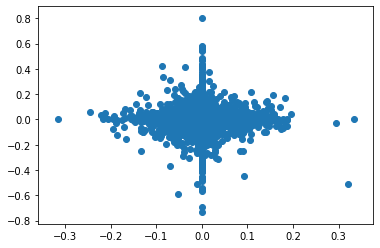

In [247]:
x = np.diff(feature_norm[:,0][98:])
y = np.diff(out_np[:])
plt.scatter(x,y)

print(np.corrcoef(x,y))
print(x.shape)
print(y.shape)